<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_5m_LSTM_CNC_without_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=c5bafb798bbb6e28ea522ef3c836899d2cf9d5371ed310a89183e188d218fa11
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [7]:
import yfinance as yf
five_m_data = yf.download(tickers='AAPL', period = '60d', interval = '5m')
five_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-02 09:30:00-04:00,146.360001,146.949997,146.089996,146.419998,146.419998,3930530
2021-08-02 09:35:00-04:00,146.449799,146.449799,145.539993,145.580002,145.580002,2639916
2021-08-02 09:40:00-04:00,145.600006,145.679993,145.270004,145.399994,145.399994,1924389
2021-08-02 09:45:00-04:00,145.500000,145.800003,145.479996,145.689896,145.689896,1643749
2021-08-02 09:50:00-04:00,145.589996,145.739899,145.369995,145.720001,145.720001,1331421
...,...,...,...,...,...,...
2021-10-25 11:45:00-04:00,148.195602,148.360001,148.149994,148.210007,148.210007,344375
2021-10-25 11:50:00-04:00,148.220001,148.399994,148.149994,148.351395,148.351395,392382
2021-10-25 11:55:00-04:00,148.348999,148.520004,148.320007,148.520004,148.520004,391858


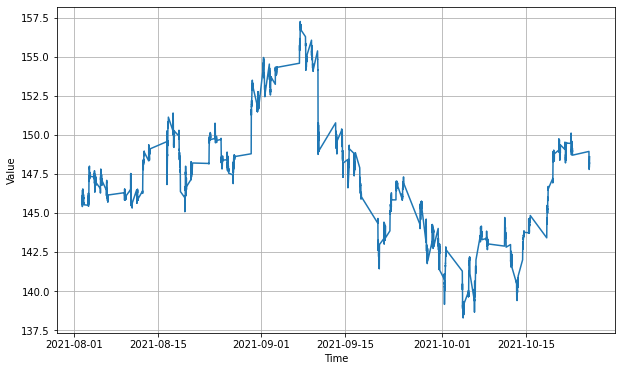

In [8]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(five_m_data.Close)
time = np.array(five_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 3500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3500,)
Epoch 1/100
14/14 [==============================] - 35s 58ms/step - loss: 125.6824 - mae: 126.1824
Epoch 2/100
14/14 [==============================] - 1s 63ms/step - loss: 121.6194 - mae: 122.1194
Epoch 3/100
14/14 [==============================] - 1s 61ms/step - loss: 115.9272 - mae: 116.4272
Epoch 4/100
14/14 [==============================] - 1s 62ms/step - loss: 109.3606 - mae: 109.8606
Epoch 5/100
14/14 [==============================] - 1s 61ms/step - loss: 102.0665 - mae: 102.5665
Epoch 6/100
14/14 [==============================] - 1s 61ms/step - loss: 93.8713 - mae: 94.3713
Epoch 7/100
14/14 [==============================] - 1s 63ms/step - loss: 84.5661 - mae: 85.0661
Epoch 8/100
14/14 [==============================] - 1s 60ms/step - loss: 73.8973 - mae: 74.3973
Epoch 9/100
14/14 [==============================] - 1s 61ms/step - loss: 62.4734 - mae: 62.9734
Epoch 10/100
1

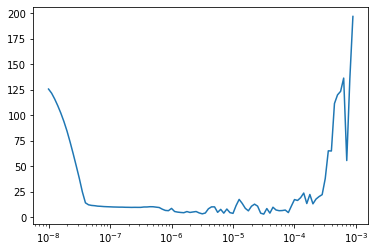

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
35/35 [==============================] - 5s 37ms/step - loss: 24.6917 - mae: 25.1747
Epoch 2/150
35/35 [==============================] - 2s 38ms/step - loss: 4.8742 - mae: 5.3445
Epoch 3/150
35/35 [==============================] - 2s 38ms/step - loss: 3.7675 - mae: 4.2314
Epoch 4/150
35/35 [==============================] - 2s 38ms/step - loss: 3.1336 - mae: 3.5921
Epoch 5/150
35/35 [==============================] - 2s 40ms/step - loss: 2.7266 - mae: 3.1837
Epoch 6/150
35/35 [==============================] - 2s 38ms/step - loss: 2.5518 - mae: 3.0079
Epoch 7/150
35/35 [==============================] - 2s 37ms/step - loss: 2.4419 - mae: 2.8997
Epoch 8/150
35/35 [==============================] - 2s 39ms/step - loss: 2.5148 - mae: 2.9755
Epoch 9/150
35/35 [==============================] - 2s 37ms/step - loss: 2.3011 - mae: 2.7621
Epoch 10/150
35/35 [==============================] - 2s 38ms/step - loss: 2.0476 - mae: 2.5015
Epoch 11/150
35/35 [===========================

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

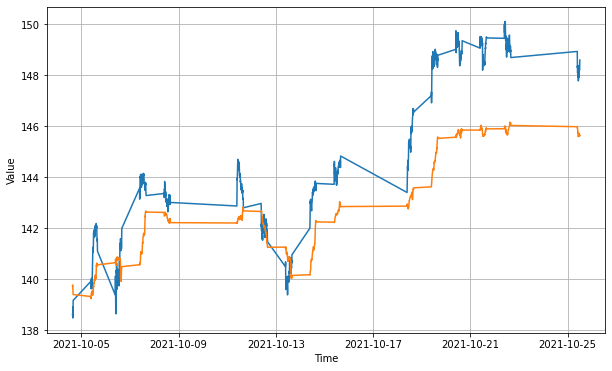

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS